# Testing wGAN for modeling COSMOS galaxies

In [1]:
%pylab inline
import pyfits as fits

Populating the interactive namespace from numpy and matplotlib


## Loading or generating data

In [2]:
x_train = fits.getdata('x_train.fits')
y_train = fits.getdata('y_train.fits')
x_test  = fits.getdata('x_test.fits')
y_test  = fits.getdata('y_test.fits')

ps = fits.getdata('ps.fits')

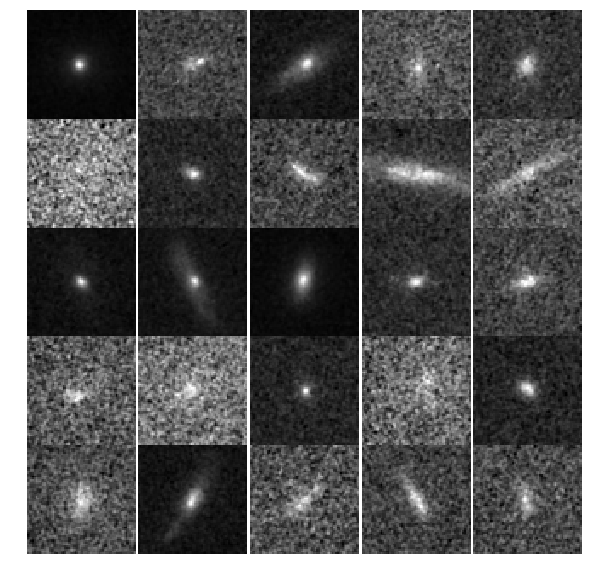

In [3]:
# plot a few examples of galaxies
figure(figsize=(10,10))
for i in range(25):
    subplot(5,5,i+1)
    imshow(x_test[i,0], interpolation='nearest', cmap='gray')
    axis('off')
subplots_adjust(wspace=0.0, hspace=0)

## Network definition

In [60]:
import tensorflow as tf
from tensorflow.contrib import slim
from tensorflow.contrib import layers
from tensorflow.contrib.slim import add_arg_scope, model_variable
from variable_clipping import MyVariableClippingOptimizer

batch_size=64

# Define the generator
@add_arg_scope
def generator(latent_code,
              conditional,
              activation_fn=tf.nn.elu,
              is_training=True,
              reuse=False,
              outputs_collections=None, scope=None):
    """
    Bottleneck residual unit variant
    """
    with tf.variable_scope(scope, 'generator', [latent_code, conditional]) as sc:

        with slim.arg_scope([slim.fully_connected, slim.conv2d_transpose],
                    activation_fn=activation_fn,
                    normalizer_fn=slim.batch_norm,
                    normalizer_params={'is_training': is_training},
                    biases_initializer=None,
                    reuse=reuse):

            # First, transform the code with the conditional
            net = tf.concat([latent_code, conditional], axis=-1)
            net = slim.fully_connected(net, 16*128, scope='fc_1')
            net = tf.reshape(net, (batch_size,4,4,-1))

            # Deconvolution
            with slim.arg_scope([slim.conv2d_transpose], padding='SAME'):
                net = slim.conv2d_transpose(net, 128, 3, stride=1, scope='conv_pre') # 4x4x128
                net = slim.conv2d_transpose(net, 64, 3, stride=2, scope='conv_1') # 8x8x64
                net = slim.conv2d_transpose(net, 32, 3, stride=2, scope='conv_2') # 16x16x32
                net = slim.conv2d_transpose(net, 16, 3, stride=2, scope='conv_3') # 32x32x16
                net = slim.conv2d_transpose(net, 8, 3, stride=2, scope='conv_4') # 64x64x8
            
        # Final layer
        net = slim.conv2d_transpose(net, 1, 3, stride=1, activation_fn=tf.nn.elu, reuse=reuse, scope='conv_out')

        return slim.utils.collect_named_outputs(outputs_collections,
                                                sc.original_name_scope,
                                                net)

# Define the critic
@add_arg_scope
def discriminator(image,
              conditional,
              activation_fn=tf.nn.elu,
              is_training=True,
              reuse=False,
              outputs_collections=None, scope=None):
    """
    Bottleneck residual unit variant
    """
    with tf.variable_scope(scope, 'discriminator', [image, conditional]) as sc:

        with slim.arg_scope([slim.fully_connected, slim.conv2d],
                    activation_fn=activation_fn,
                    normalizer_fn=slim.batch_norm,
                    biases_initializer=None,
                    normalizer_params={'is_training': is_training},
                    reuse=reuse):
            
            # First, process the input image with a cnn
            with slim.arg_scope([slim.conv2d], padding='SAME'):
                net = slim.conv2d(image, 16, 3, stride=2, scope='pre_conv') # 64x64x16
                net = slim.conv2d(net, 32, 3, stride=2, scope='conv_1') # 16x16x32
                net = slim.conv2d(net, 64, 3, stride=2, scope='conv_2') # 8x8x64
                net = slim.conv2d(net, 128, 3, stride=2, scope='conv_3') # 4x4x128
            
            # Combine with conditional values
            net = tf.reshape(net, (batch_size,-1))
            net = tf.concat([net, conditional], axis=-1)
            net = slim.fully_connected(net, 1024, scope='fc_1')
            net = slim.fully_connected(net, 128, scope='fc_2')

        # Final layer
        net = slim.fully_connected(net, 1, scope='fc_out', activation_fn=None, reuse=reuse)            

        return slim.utils.collect_named_outputs(outputs_collections,
                                                sc.original_name_scope,
                                                net)    

In [88]:
# Model definition
code_size=128
nx=64
ny=3
diter_default= 5
lr_crit=0.0001
lr_gen=0.0001

# Reset model
tf.reset_default_graph()

input_image = tf.placeholder(tf.float32, (batch_size, nx, nx, 1))
input_cond  = tf.placeholder(tf.float32, (batch_size, ny))
input_code  = tf.placeholder(tf.float32, (batch_size, code_size))

random_code = tf.random_normal(shape=(batch_size, code_size), dtype=tf.float32)

gen_image  = generator(random_code, input_cond, scope='gen')
gen_image_test = generator(input_code, input_cond, scope='gen', reuse=True, is_training=False)

crit_real = discriminator(input_image, input_cond, scope='crit')
crit_fake = discriminator(gen_image, input_cond, scope='crit', reuse=True)

# Define the two losses
crit_loss = tf.reduce_mean(crit_real - crit_fake)
gen_loss  = tf.reduce_mean(crit_fake)

# Isolate the parameters to train in the 2 phases
crit_params = [v for v in tf.trainable_variables() if'crit/' in v.name]
gen_params = [v for v in tf.trainable_variables() if'gen/' in v.name]

# Create the optimizers
crit_opt = MyVariableClippingOptimizer(tf.train.RMSPropOptimizer(learning_rate=lr_crit), 0.01)
gen_opt  = tf.train.RMSPropOptimizer(learning_rate=lr_gen)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    opt_op_crit = crit_opt.minimize(crit_loss, var_list=crit_params)
    opt_op_gen = gen_opt.minimize(gen_loss, var_list=gen_params)

In [89]:
# Open a session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [98]:
nbatch = len(x_train) / batch_size

gen_iterations=0
nepochs=1000

for ep in range(nepochs):
    
    b = 0
    
    inds = permutation(len(x_train))  
    for b in range(nbatch):
        
        # Train the discriminator Diter times
        if gen_iterations < 25 or gen_iterations % 500 == 0:
            Diters = 100
        else:
            Diters = diter_default
        inds_crit = permutation(len(x_train))
        m_crit=0
        for b_crit in range(Diters):
            batch_image = x_train[inds_crit[b_crit*batch_size:(b_crit+1)*batch_size]].reshape((-1,64,64,1))
            batch_cond  = y_train[inds_crit[b_crit*batch_size:(b_crit+1)*batch_size]]
            
            # Update the critic
            _,cl = sess.run([opt_op_crit, crit_loss], feed_dict={input_image:batch_image, 
                                                                 input_cond: batch_cond})
            m_crit += cl
            
        # Train the generator
        batch_image = x_train[inds[b*batch_size:(b+1)*batch_size]].reshape((-1,64,64,1))
        batch_cond  = y_train[inds[b*batch_size:(b+1)*batch_size]]
        
        _, gl = sess.run([opt_op_gen, gen_loss], feed_dict={input_image:batch_image, input_cond: batch_cond})
        gen_iterations +=1 
        if b %100 ==0:
            print ep, b, gl, m_crit/Diters

0 0 0.137696 -0.249149781018
0 100 0.153754 -0.255960538983
0 200 0.145438 -0.254592141509
0 300 0.139535 -0.260271328688
0 400 0.124155 -0.256422328949
0 500 0.153427 -0.253588867635
0 600 0.145937 -0.257227760553
0 700 0.150893 -0.249474266171
0 800 0.141085 -0.256821513176
0 900 0.139667 -0.246629500389
0 1000 0.144635 -0.251875868589
1 0 0.149606 -0.251437824965
1 100 0.152282 -0.253032916784
1 200 0.14717 -0.253008842468
1 300 0.143828 -0.255098676682
1 400 0.129087 -0.251627677679
1 500 0.142735 -0.25334071219
1 600 0.138609 -0.251481315494
1 700 0.139847 -0.248432126641
1 800 0.136605 -0.253682339191
1 900 0.146849 -0.245222648978
1 1000 0.135635 -0.244691076875
2 0 0.14116 -0.250809705257
2 100 0.139504 -0.259001541138
2 200 0.143466 -0.238710308075
2 300 0.142965 -0.241402852535
2 400 0.151971 -0.252253782749
2 500 0.131599 -0.251883691549
2 600 0.14802 -0.255215805769
2 700 0.149406 -0.251009613276
2 800 0.146425 -0.25261143446
2 900 0.131051 -0.253071826696
2 1000 0.14449 -0

23 900 0.123422 -0.241219267249
23 1000 0.142088 -0.244168221951
24 0 0.125443 -0.243505612016
24 100 0.13445 -0.248748141527
24 200 0.117773 -0.242177018523
24 300 0.125268 -0.234750103951
24 400 0.129061 -0.239585629106
24 500 0.141223 -0.252544784546
24 600 0.122419 -0.221926045418
24 700 0.121912 -0.234693539143
24 800 0.137648 -0.23431212306
24 900 0.146142 -0.246849814057
24 1000 0.140196 -0.244699764252
25 0 0.127839 -0.244287106395
25 100 0.0987243 -0.242906868458
25 200 0.122928 -0.232537257671
25 300 0.122024 -0.229709336162
25 400 0.11787 -0.223246213794
25 500 0.127181 -0.236551824212
25 600 0.134146 -0.249142315984
25 700 0.129579 -0.251032909751
25 800 0.135901 -0.246564275026
25 900 0.110532 -0.232322815061
25 1000 0.139119 -0.24539488554
26 0 0.131914 -0.248915874958
26 100 0.127958 -0.211192688346
26 200 0.115812 -0.248427465558
26 300 0.128053 -0.237811338902
26 400 0.129965 -0.241062626243
26 500 0.129786 -0.243913298845
26 600 0.134865 -0.233163332939
26 700 0.11007

KeyboardInterrupt: 

In [108]:
im = sess.run(gen_image, feed_dict={input_image:batch_image, input_cond: batch_cond})

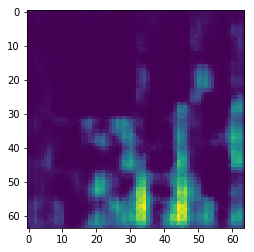

In [109]:
imshow(im[6,:,:,0])